In [1]:
# importing all necesary modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from sklearn.metrics import mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor
import pickle
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# read data from file
def ReadData(data_dir, fnames):
    df = pd.read_csv(data_dir + fname, parse_dates=['date'], index_col='date')
    return df

# manualy define wich files to process
data_dir = 'Data/'
fname = 'train.csv'

# задаём размер рисунков
plt.rcParams['figure.figsize'] = (15,12)
sns.set()

df = pd.read_csv(data_dir + fname)

In [3]:
# reading the data
df.head()

,event_country_code,batt_manufacturer,installed_count,batt_instance,cycle_count,temperature,battery_current,design_capacity,full_charge_capacity,remaining_capacity,design_voltage,batt_voltage,cell_voltage1,cell_voltage2,cell_voltage3,cell_voltage4,status_register,risk
0,IV,33-24,1,primary,335,36,62999,4450,3473,1605,11400,12535,0,3457,3458,3447,192,-1
1,JP,333-2B-0F,1,primary,16,22,63291,5200,4827,1801,7700,12535,0,0,3498,3512,192,-1
2,US,333-1C-2F,1,primary,16,28,0,4080,3851,3707,11400,12535,0,4265,4265,4264,224,-1
3,US,13-42,1,primary,371,20,237,4450,3293,3018,11400,12535,0,4325,4274,4277,128,-1
4,IV,33-42,1,primary,63,33,0,4450,3819,3615,11400,12535,0,4245,4248,4246,224,-1


In [4]:
# quick look at the data
df.describe()

,installed_count,cycle_count,temperature,battery_current,design_capacity,full_charge_capacity,remaining_capacity,design_voltage,batt_voltage,cell_voltage1,cell_voltage2,cell_voltage3,cell_voltage4,status_register,risk
count,86954.000000,86954.000000,86954.000000,86954.000000,86954.000000,86954.000000,86954.000000,86954.000000,86954.000000,86954.000000,86954.000000,86954.000000,86954.000000,86954.000000,86954.000000
mean,1.004865,163.042528,29.305242,17554.370357,4057.864745,3651.617223,3069.510040,11398.079789,12534.922120,303.895048,3928.965085,4089.479782,4055.003956,1485.880132,43.578927
std,0.069578,157.054658,4.750972,28454.219297,1123.447969,1270.159188,1346.188191,1208.573139,8.406005,1071.784932,830.367850,284.959325,446.065275,5800.829904,101.062957
min,1.000000,0.000000,0.000000,0.000000,2500.000000,1.000000,0.000000,3800.000000,11289.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,1.000000,35.000000,26.000000,0.000000,4080.000000,3323.000000,1998.000000,11100.000000,12535.000000,0.000000,3921.000000,3968.000000,3954.000000,192.000000,-1.000000
50%,1.000000,97.000000,29.000000,173.000000,4080.000000,3799.000000,3362.000000,11400.000000,12535.000000,0.000000,4143.000000,4152.000000,4154.000000,224.000000,-1.000000
75%,1.000000,309.000000,32.000000,63343.000000,4450.000000,3978.000000,3790.000000,11400.000000,12535.000000,0.000000,4273.000000,4279.000000,4278.000000,224.000000,0.000000
max,2.000000,983.000000,55.000000,65433.000000,79538.000000,79538.000000,27114.000000,15551.000000,12554.000000,4398.000000,4398.000000,4400.000000,4399.000000,49376.000000,440.000000


In [5]:
len(np.unique(df.batt_manufacturer))
# аж 80 производителей батарей

80

In [6]:
# adding 'OK' feature if risk != 0
df['OK'] = np.where(df['risk']==0, 0, 1)
# how many good and bad batteries
df.OK.value_counts()

1    84289
0     2665
Name: OK, dtype: int64

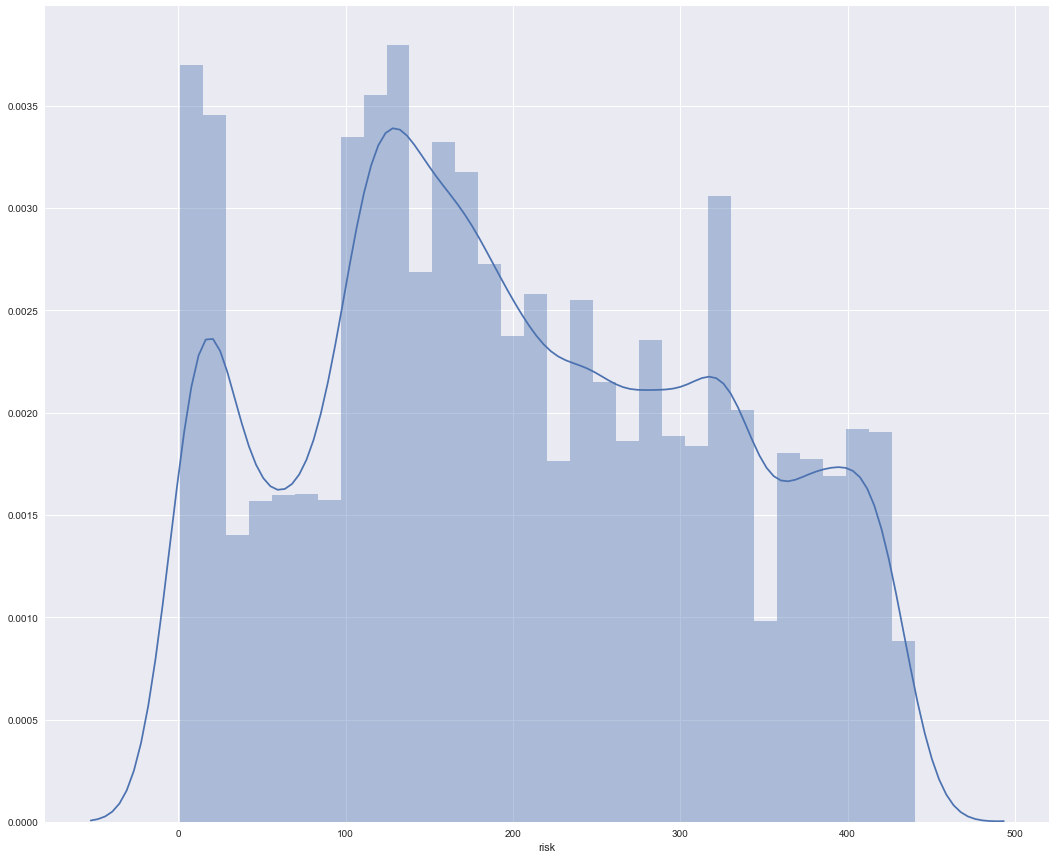

In [17]:
# looking at 'risk' distribution
sns.distplot(df[df.risk > 0].risk)

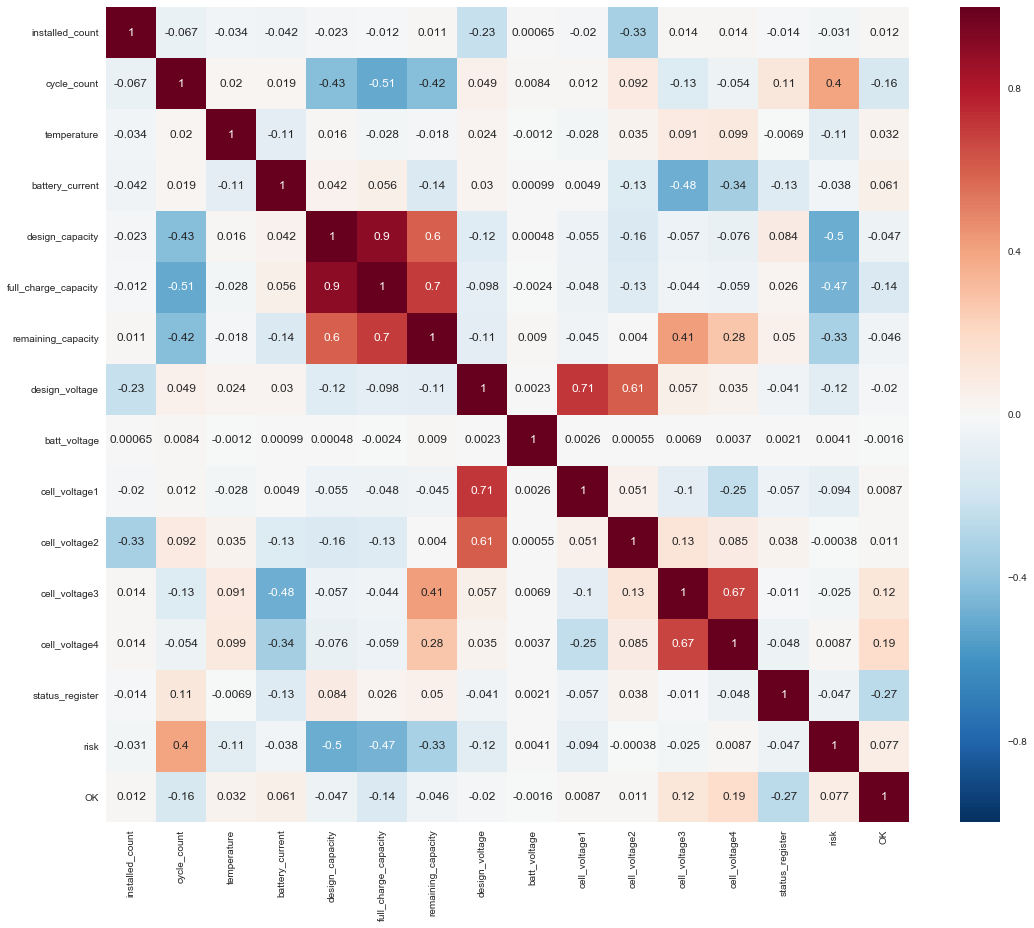

In [15]:
# and at features dependences
plt.rcParams['figure.figsize'] = (18,15)
sns.heatmap(df.corr(), annot=True)

Seems that no one feature powerfully affects to risk value. A little more than others 'cycle_counts', 'design_capacity' and	'full_charge_capacity' correlated to 'risk'. And we can say almost nothing about correlation between features and 'OK' variable with describes if a battery OK.